<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2022/blob/main/Seminars/lab2_1_regression_seminar%20solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Today's data

400 fotos of human faces. Each face is a 2d array [64x64] of pixel brightness.

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces().images

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


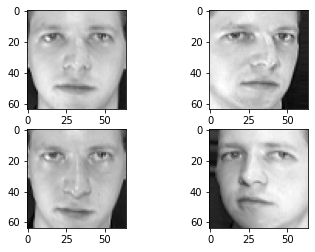

In [ ]:
# this code showcases matplotlib subplots. The syntax is: plt.subplot(height, width, index_starting_from_1)
plt.subplot(2,2,1)
plt.imshow(data[0],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(data[1],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(data[2],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(data[3],cmap='gray')

# Face reconstruction problem

Let's solve the face reconstruction problem: given left halves of facex __(X)__, our algorithm shall predict the right half __(y)__. Our first step is to slice the photos into X and y using slices.

__Slices in numpy:__
* In regular python, slice looks roughly like this: `a[2:5]` _(select elements from 2 to 5)_
* Numpy allows you to slice N-dimensional arrays along each dimension: [image_index, height, width]
  * `data[:10]` - Select first 10 images
  * `data[:, :10]` - For all images, select a horizontal stripe 10 pixels high at the top of the image
  * `data[10:20, :, -25:-15]` - Take images [10, 11, ..., 19], for each image select a _vetrical stripe_ of width 10 pixels, 15 pixels away from the _right_ side.

__Your task:__

Let's use slices to select all __left image halves as X__ and all __right halves as y__.

In [ ]:
data.shape

In [ ]:
# select left half of each face as X, right half as Y
X = data[:, :, :32]
y = data[:, :, 32:]

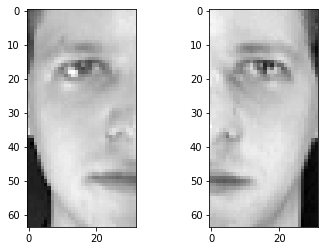

In [ ]:
# If you did everything right, you're gonna see left half-image and right half-image drawn separately in natural order
plt.subplot(1,2,1)
plt.imshow(X[0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y[0],cmap='gray')

assert X.shape == y.shape == (len(data), 64, 32), "Please slice exactly the left half-face to X and right half-face to Y"

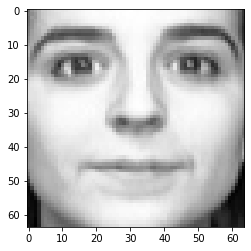

In [ ]:
def glue(left_half,right_half):
    # merge photos back together
    left_half = left_half.reshape([-1, 64, 32])
    right_half = right_half.reshape([-1, 64, 32])
    return np.concatenate([left_half, right_half], axis=-1)


# if you did everything right, you're gonna see a valid face
plt.imshow(glue(X, y)[99], cmap='gray')

# Linear regression

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape([len(X), -1]),
                                                    y.reshape([len(y), -1]),
                                                    test_size=0.05, random_state=42)

print(X_test.shape)

(20, 2048)


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

measure mean squared error

In [ ]:
from sklearn.metrics import mean_squared_error

print("Train MSE:", mean_squared_error(Y_train, model.predict(X_train)))
print("Test MSE:", mean_squared_error(Y_test, model.predict(X_test)))

Train MSE: 3.2086968e-12
Test MSE: 0.0102840215


## Why train error is much smaller than test?

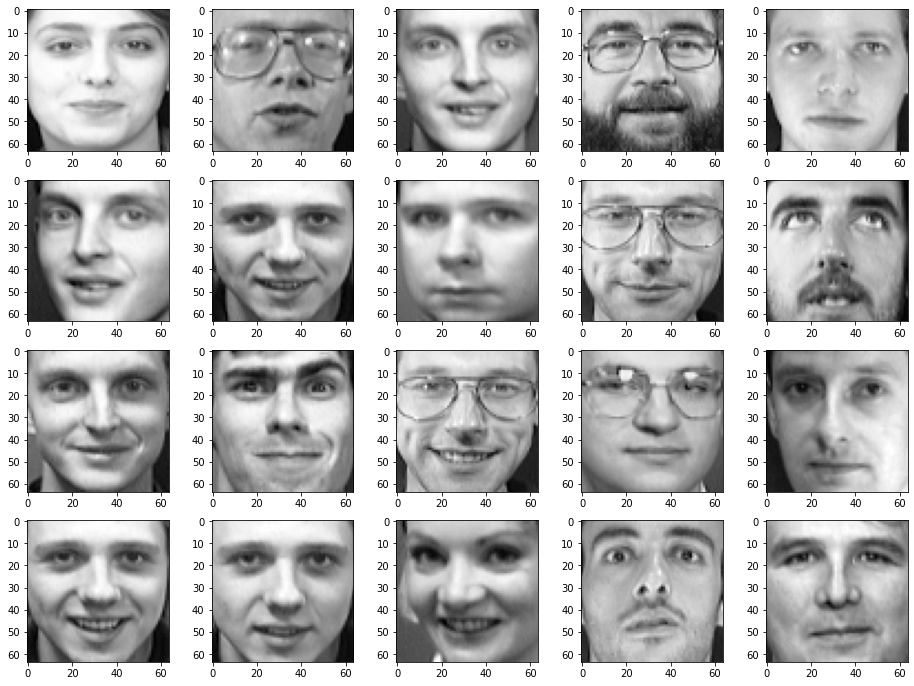

In [ ]:
# Train predictions
pics = glue(X_train,model.predict(X_train)) # reconstruct and glue together X and predicted Y for the train dataset

plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

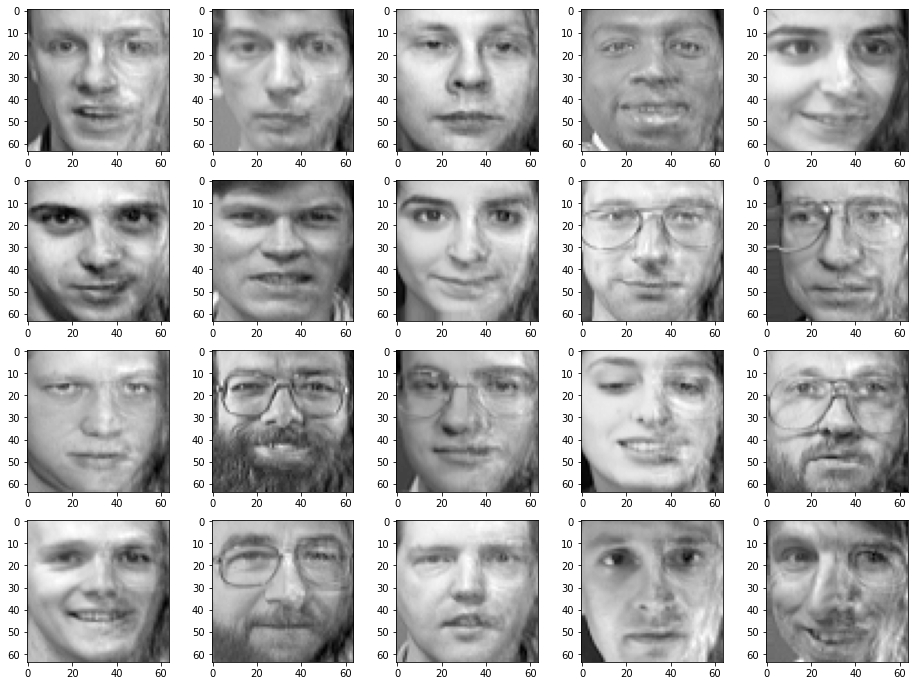

In [ ]:
# Test predictions
pics = glue(X_test,model.predict(X_test)) # reconstruct and glue together X and predicted Y for the test dataset

plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

### Regularisation

There are  many linear models in sklearn package, and all of them can be found [here](https://scikit-learn.org/stable/modules/linear_model.html). We will focus on 3 of them: Ridge regression, Lasso and ElasticNet.
Idea of all of them is very simple: add some penalty to the objective loss function to prevent overfitting.

# Ridge regression
RidgeRegression is just a LinearRegression, with l2 regularization - penalized for $ \alpha \cdot \sum _i w_i^2$

Let's train such a model with alpha=0.5

In [ ]:
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
 
ridge = Ridge(alpha=10)
ridge.fit(X_train, Y_train)
 
print("Train MSE:", mean_squared_error(Y_train, ridge.predict(X_train)))
print("Test MSE:", mean_squared_error(Y_test, ridge.predict(X_test)))

Train MSE: 0.003446036
Test MSE: 0.0074274773


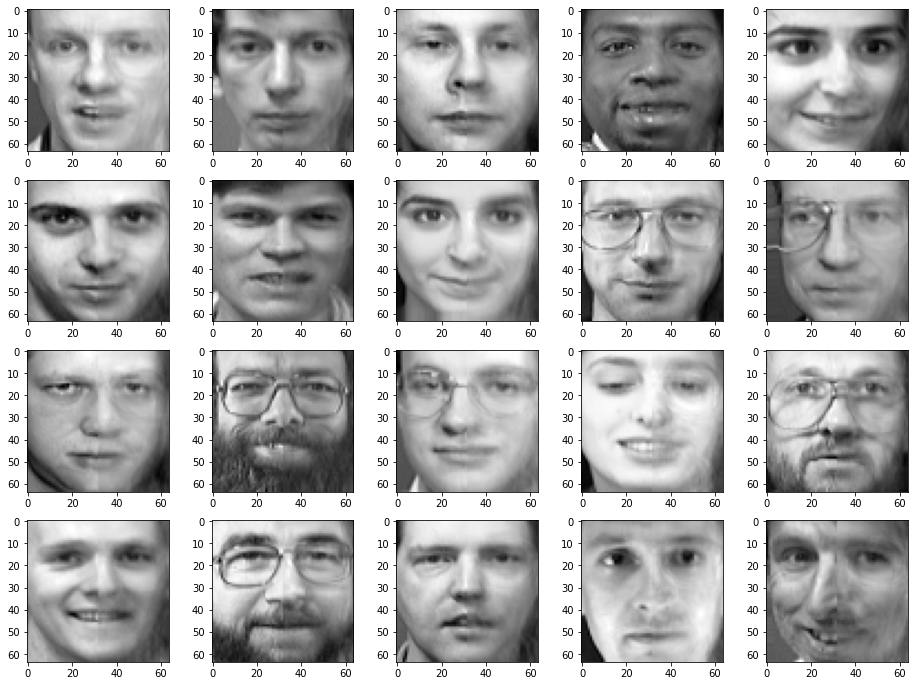

In [ ]:
# Test predictions
pics =glue(X_test,ridge.predict(X_test)) # reconstruct and glue together X and predicted Y for the test dataset

plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

# Finding the best `alpha` (grid search)

`sklearn` has a pre-implemented class - `sklearn.model_selection.GridSearchCV` - that wraps your model and optimizes its hyperparameters using K-fold cross-validation. The hyperparameter values are taken from a finite set of values in a rectangular grid (therefore, the method is called grid search). In order to use it, you need to set the hyperparameter values grid, the metric you want to optimize and the number of folds from the cross-validation.

In [ ]:
from sklearn.model_selection import GridSearchCV

Fitting 5 folds for each of 13 candidates, totalling 65 fits


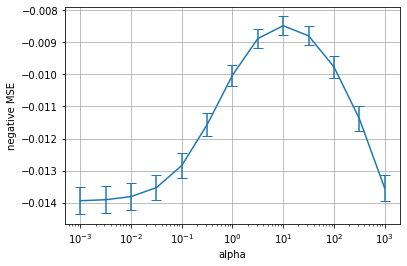

In [ ]:
parameter_dict = {
    "alpha" : np.logspace(-3, 3, 13, base=10)
}

gscv = GridSearchCV(
    estimator=Ridge(), # our model to optimize
    param_grid=parameter_dict, # grid of parameter values
    scoring='neg_mean_squared_error', # metric - it needs to be a score, so
                                      # we take the negative MSE
    cv=5, verbose=2, n_jobs=-1
)
gscv.fit(X_train, Y_train)

plt.errorbar(gscv.param_grid['alpha'],
             gscv.cv_results_['mean_test_score'],
             gscv.cv_results_['std_test_score'] / gscv.cv**0.5,
             capsize=5)
plt.xscale("log", nonposx='clip')
plt.xlabel("alpha")
plt.ylabel("negative MSE")
plt.grid()

Now you can find the best model as `gscv.best_estimator_`. Use it to make the reconstruction on the test again:

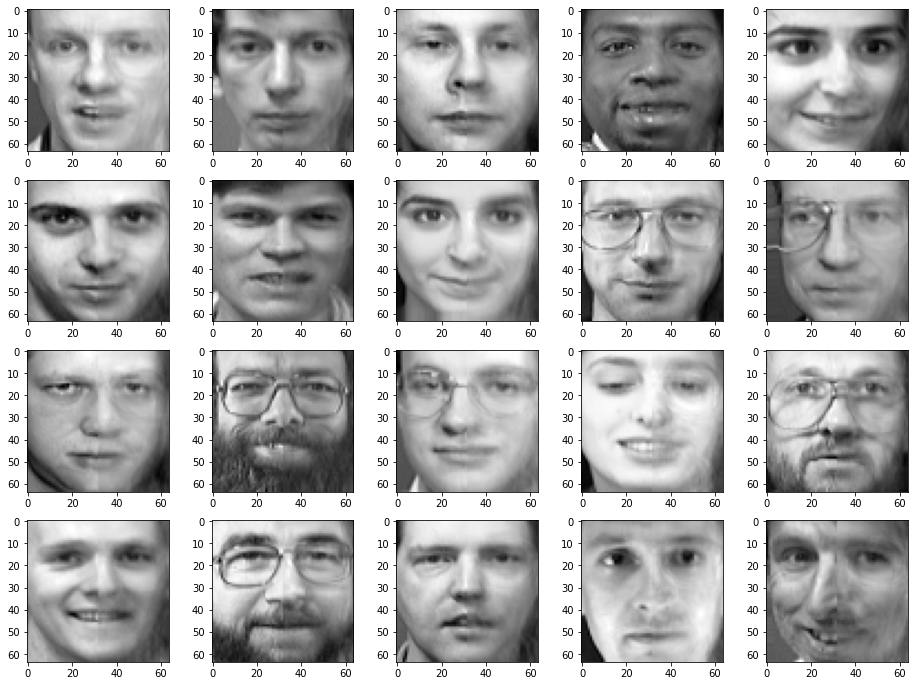

In [ ]:
# Test predictions
pics = glue(X_test, gscv.best_estimator_.predict(X_test))
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# Use the code above to do GridSearch for Lasso and/or ElasticNet
# models. Note that Lasso and ElasticNet are *much*
# slower to fit, compared to Ridge (especially for small alpha).
<YOUR CODE>

## Add transformers and make a pipeline

```python
some_transformer = sklearn.some_module.SomeTransformerClass(some_parameters) # create the transformer object
some_transformer.fit(X, y) # learn how to transform the data (e.g.
                           # for StandardScaler, calculate mean and std of columns in X)
some_transformer.transform(X) # transform the features
```

In [ ]:
#<YOUR TURN>
#make a new Ridge model using a pipeline with StandardScaler() and  Ridge regression
#fit the model and print 'Train MSE' and 'Test MSE'


This pipeline can be used within grid search CV, e.g.:

In [ ]:
parameter_dict = {
    "ridge__alpha" : np.logspace(-1, 7, 9, base=10) # note the 'ridge__' prefix
                                                    # that tells to which step
                                                    # of the pipeline this
                                                    # parameter belongs
}

gscv = GridSearchCV(
    estimator=model,
    param_grid=parameter_dict,
    scoring='neg_mean_squared_error',
    cv=5, verbose=2, n_jobs=-1
)
gscv.fit(X_train, Y_train)


plt.errorbar(gscv.param_grid['ridge__alpha'],
             gscv.cv_results_['mean_test_score'],
             gscv.cv_results_['std_test_score'] / gscv.cv**0.5,
             capsize=5)
plt.xscale("log", nonposx='clip')
plt.xlabel("alpha")
plt.ylabel("negative MSE")
plt.grid()

See also:
- [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - scaling based on min and max values of the feature
- [sklearn.preprocessing.RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) - scaling that ignores the tails of the feature distribution (more robust to outliers)
- [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - one-hot encoding for categorical features
- [sklearn.preprocessing.FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) - transformation using arbitrary (e.g. user defined) python function
- [sklearn.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) - tool that allows composing complicated nested structures of transformers (e.g. for using different transformers for different features)
-[sklearn.compose.make_column_selector](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html) - tool for selection columns with specified data type

# Outliers impact on regression

Remember, that when we minimise loss
$$
MSE = (\hat y - y)^2
$$

which penalise more to for heigher values of error. What is that impact of this for the dataset with outliers, what do you think?

Here is an example of regression fitted with ordinary LR and RANSAC, which iteratively trains on random subsamples of the data, trying to identify outliers.

`class sklearn.linear_model.RANSACRegressor(base_estimator=None, *, min_samples=None, residual_threshold=None, is_data_valid=None, is_model_valid=None, max_trials=100, max_skips=inf, stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss='absolute_error', random_state=None)`

RANSAC regressor algorithm:
- Select min_samples random samples from the original data and check whether the set of data is valid (see is_data_valid).

- Fit a model to the random subset (base_estimator.fit) and check whether the estimated model is valid (see is_model_valid).

- Classify all data as inliers or outliers by calculating the residuals to the estimated model (base_estimator.predict(X) - y) - all data samples with absolute residuals smaller than or equal to the residual_threshold are considered as inliers.

- Save fitted model as best model if number of inlier samples is maximal. In case the current estimated model has the same number of inliers, it is only considered as the best model if it has better score.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


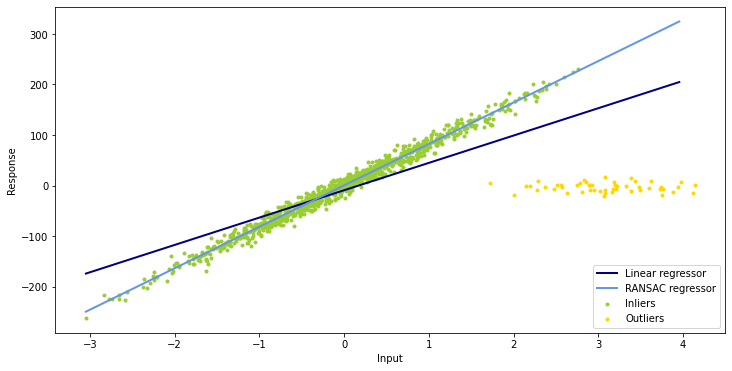

In [ ]:
plt.figure(figsize=(12,6))
lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

## Bonus part

Try using `sklearn.linear_model.SGDRegressor` with `huber` loss in the code above instead of `LinearRegression`. Is it better in this case? Try varying its `epsilon` parameter.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with Huber regression
huber = linear_model.HuberRegressor(epsilon=2)
huber.fit(X, y)
 
# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_huber = huber.predict(line_X)


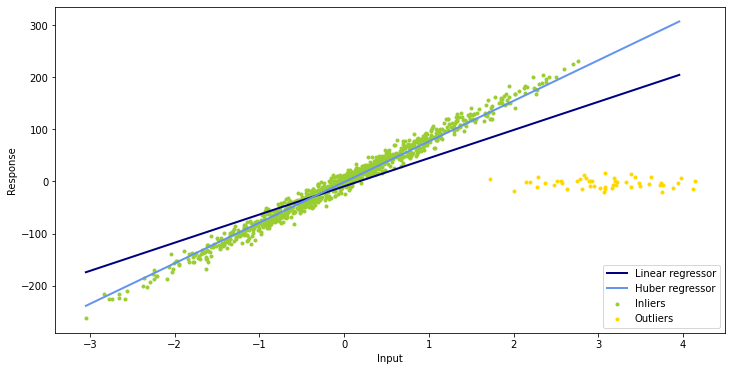

In [ ]:
plt.figure(figsize=(12,6))
lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_huber, color='cornflowerblue', linewidth=lw,
         label='Huber regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()